----
<h1><b>News Classifier</b></h1>
<p> - Konark Verma</p>
<br>
<p><b>Problem Statement:</b></p><p>Here we are taking a set of news articles from BBC and we want to built a Deep Learning System that could help us classify these news articles into various categories.</p>
<p>We would also like to experiment with pre-trained Glove Embeddings to see their effect on learning and classification.</p>
<br>
<p><b>Real-world/Business objectives and constraints:</b>
<ol>
<li>Minimize multi-class error.</li>
<li>Multi-class probability estimates.</li>
<li>Classification talk must finish within a few seconds.</li>
</ol>


In [1]:
# Importing the required libraries.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


----
<h3><b>Collecting the data</b></h3>

<p><b>Data:</b></p><p>Our dataset contains a news articles from BBC News, the link for which is as follows: </br><a>https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv</a></p>

<b>Data sample:</b><br>
<p><i>
Category : Sport
<br>
Text : Wilkinson fit to face edinburgh england captain jonny wilkinson will make his long-awaited return from injury against edinburgh on saturday. Wilkinson  who has not played since injuring his bicep on 17 october took part in full-contact training with newcastle falcons on wednesday. and the 25-year-old fly-half will start saturday s heineken cup match at murrayfield on the bench. but newcastle director of rugby rob andrew said:  he s fine and we hope to get him into the game at some stage.  the 25-year-old missed england s autumn internationals after aggravating the haematoma in his upper right arm against saracens. he was subsequently replaced as england captain by full-back jason robinson. sale s charlie hodgson took over the number 10 shirt in the internationals against canada  south africa and australia. wilkinson s year has been disrupted by injury as his muscle problem followed eight months on the sidelines with a shoulder injury sustained in the world cup final.
</i></p>

In [2]:
# Obtaining the BBC News articles dataset.
!wget no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
-O /tmp/bbc-text.csv

--2020-06-23 02:17:56--  http://no-check-certificate/
Resolving no-check-certificate (no-check-certificate)... failed: Name or service not known.
wget: unable to resolve host address ‘no-check-certificate’
--2020-06-23 02:17:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2020-06-23 02:17:56 (105 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]

FINISHED --2020-06-23 02:17:56--
Total wall clock time: 0.09s
Downloaded: 1 files, 4.8M in 0.05s (105 MB/s)


----
<h3><b>Exploratory Data Analysis</b></h3>

Number of news articles in our dataset: 2225
Number of unique words in our dataset: 29726

Minimum length of a sentence 91
Maximum length of a sentence 4491



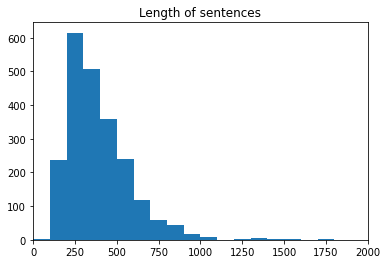


Classes in our dataset: Politics, Entertainment, Tech, Business, Sport, 

In [3]:
# Counting the number of lines in our dataset.
with open('/tmp/bbc-text.csv') as file:
    data = file.read().split('\n')[1:-1]
    lines = len(data)
print('Number of news articles in our dataset:', lines)

# Counting the number of unique words in our dataset.
sentences, labels = [], []
for line in data:
    line = line.split(',')
    labels.append(line[0])
    sentences.append(line[1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
words = len(tokenizer.word_index)
print('Number of unique words in our dataset:', words)
print()

# Finding the minumum and maximum number of words in a sentence.
data_tokenized = tokenizer.texts_to_sequences(sentences)
lines_length = [len(sentence) for sentence in data_tokenized if len(sentence)>1]
print('Minimum length of a sentence', min(lines_length))
print('Maximum length of a sentence', max(lines_length))
print()

# Plotting a graph representing the words in different sentences.
plt.title('Length of sentences')
plt.hist(lines_length, bins=np.arange(0,2000,100))
plt.xlim([0, 2000])
plt.show()

# Printing all the classes of our news articles.
print('\nClasses in our dataset:', end=' ')
for i in set(labels):
    print(i.capitalize(), end=', ')

-----
<h3><b>Preparing the Data</b></h3>
<p><b>Steps:</b></p>
<ol>
<li>Spliting the first word from each line to get the label and the text</li>
<li>Removing Stopwords from text</li>
<li>Applying Lemmatization on the text</li>
<li>Tokenizing the text data</li>
<li>Pre-padding the sentences to make them of equal lengths</li>
<li>Splitting the dataset randomly to form train and test datasets</li>
</ol>


In [4]:
# Reading the data and splitting it into sentences and labels.
with open('/tmp/bbc-text.csv') as file:
    data = file.read().split('\n')[1:-1]
sentences, labels = [], []
stopwords = set([ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ])

# Removing all the stopwords and applying lemmatization.
lemmatizer = WordNetLemmatizer()
for line in data:
    temp = line.split(',')
    labels.append(temp[0])
    temp = re.sub('[^a-zA-Z ]+', ' ', temp[1])
    temp = temp.split()
    sentence = ''
    for word in temp:
        if word not in stopwords:
            sentence = sentence+lemmatizer.lemmatize(word)+' '
    sentences.append(sentence[:-1])

In [5]:
# Tokenizing the words and pre-padding them with zeros.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences)

In [6]:
# Converting the label-names to label-ids.
labels_name_to_id, labels_id_to_name = {}, {}
for i, label in enumerate(list(set(labels))):
    labels_name_to_id[label] = i
    labels_id_to_name[i] = label
for i in range(len(labels)):
    labels[i] = labels_name_to_id[labels[i]]
labels = np.array(labels)

In [7]:
# Splitting the data randomly.
x_train, x_test, y_train, y_test = train_test_split(sequences_padded, labels, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1780, 2374), (445, 2374), (1780,), (445,))

----
<b>Glove Embeddings:</b>
<p>
Now we download the pre-trained word vectors.<br>
We would like to experiment with these word embeddings and see their effects on training as well as prediction.
</p>

In [8]:
# Downloading the glove embeddings and unzipping them.
!wget no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/embeddings.zip
!unzip /tmp/embeddings.zip -d /tmp/ 

--2020-06-23 02:18:08--  http://no-check-certificate/
Resolving no-check-certificate (no-check-certificate)... failed: Name or service not known.
wget: unable to resolve host address ‘no-check-certificate’
--2020-06-23 02:18:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-23 02:18:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-23 02:18:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to dow

In [9]:
# Reading the pretrained glove embeddings.
embeddings = {}
with open('/tmp/glove.6B.100d.txt') as file:
    temp = file.read().split('\n')[:-1]
    for line in temp:
        tempu = line.split()
        embeddings[tempu[0]] = np.array(tempu[1:], dtype='float32')

# Preparing the embedding weight matrix.
embedding_matrix = (np.random.rand(vocab_size+1,100)-0.5)/100
for word in tokenizer.word_index:
    if word in embeddings.keys():
        embedding_matrix[tokenizer.word_index[word],:] = embeddings[word]

----
<h3><b>Training the model</b></h3>
<p>We are using a Sequential model with the following layers:</p>
<ol>
<li>Embedding</li>
<li>Global Average Pooling 1D</li>
<li>Dense (32)</li>
<li>Dense (5)</li>
</ol>

<p>We would like to work with the following models:</p>
<ol>
<li>No pre-trained embeddings</li>
<li>Non-trainable pre-trained embeddings</li>
<li>Trainable pre-trained embeddings</li>
</ol>

<p>We are also using the following parameters:</p>
<ul>
<li>vocab_size = False</li>
<li>maxlen = False</li>
<li>wv_dims = 100</li>
<li>input_length = x_train.shape[1]</li>
<li>epochs = 100</li>
</ul>

In [10]:
# Building and Training a model.

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size+1, 100, input_length=x_train.shape[1]))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2374, 100)         2476400   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,479,797
Trainable params: 2,479,797
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 3s 62ms/step - loss: 1.6018 - accuracy: 0.2309 - val_loss: 1.5984 - val_accuracy: 0.2270
Epoch 2/100
56/56 [==============================] - 3s 59ms/step - loss: 1.5929 - accuracy: 0.2669 - 

In [11]:
# Building and Training a model, with non-trainable glove embeddings.

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size+1, 100, input_length=x_train.shape[1], weights=[embedding_matrix], trainable=False))
model1.add(tf.keras.layers.GlobalAveragePooling1D())
model1.add(tf.keras.layers.Dense(32, activation='relu'))
model1.add(tf.keras.layers.Dense(5, activation='softmax'))

model1.summary()
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2374, 100)         2476400   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 2,479,797
Trainable params: 3,397
Non-trainable params: 2,476,400
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 1s 19ms/step - loss: 1.5782 - accuracy: 0.4916 - val_loss: 1.5469 - val_accuracy: 0.6607
Epoch 2/100
56/56 [==============================] - 1s 18ms/step - loss: 1.5076 - accuracy: 0.6

In [12]:
# Building and Training a model, with trainable glove embeddings.

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size+1, 100, input_length=x_train.shape[1], weights=[embedding_matrix], trainable=True))
model2.add(tf.keras.layers.GlobalAveragePooling1D())
model2.add(tf.keras.layers.Dense(32, activation='relu'))
model2.add(tf.keras.layers.Dense(5, activation='softmax'))

model2.summary()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2374, 100)         2476400   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 2,479,797
Trainable params: 2,479,797
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 3s 58ms/step - loss: 1.5686 - accuracy: 0.4421 - val_loss: 1.5305 - val_accuracy: 0.6337
Epoch 2/100
56/56 [==============================] - 3s 59ms/step - loss: 1.4768 - accuracy: 0.6713 

----
<h3><b>Plotting the training accuracy and training loss</b></h3>

Here we are plotting the training accuracy and training loss for all these models.

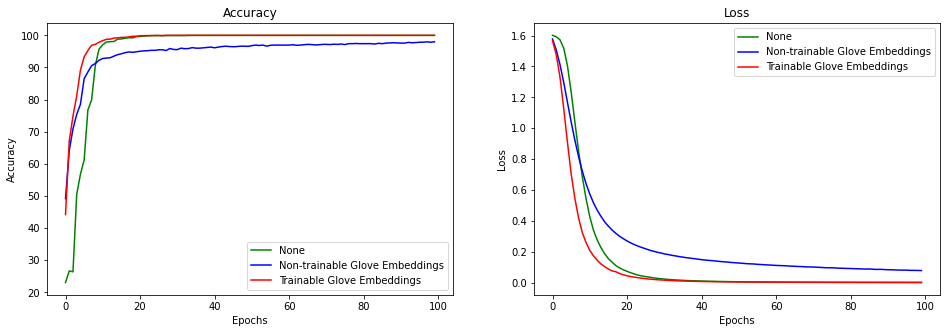

In [13]:
# Getting the values of accuracy and loss from history.
accuracy = np.array(history.history['accuracy'])*100
loss = history.history['loss']
epochs = range(len(accuracy))
accuracy1 = np.array(history1.history['accuracy'])*100
loss1 = history1.history['loss']
epochs1 = range(len(accuracy1))
accuracy2 = np.array(history2.history['accuracy'])*100
loss2 = history2.history['loss']
epochs2 = range(len(accuracy2))

# Plotting the graphs.
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title('Accuracy')
plt.plot(epochs, accuracy, 'g', label='None')
plt.plot(epochs1, accuracy1, 'b', label='Non-trainable Glove Embeddings')
plt.plot(epochs2, accuracy2, 'r', label='Trainable Glove Embeddings')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(122)
plt.title('Loss')
plt.plot(epochs, loss, 'g', label='None')
plt.plot(epochs1, loss1, 'b', label='Non-trainable Glove Embeddings')
plt.plot(epochs2, loss2, 'r', label='Trainable Glove Embeddings')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

----
<h3><b>Plotting the validation accuracy and validation loss</b></h3>

Here we are plotting the validation accuracy and validation loss for all these models.

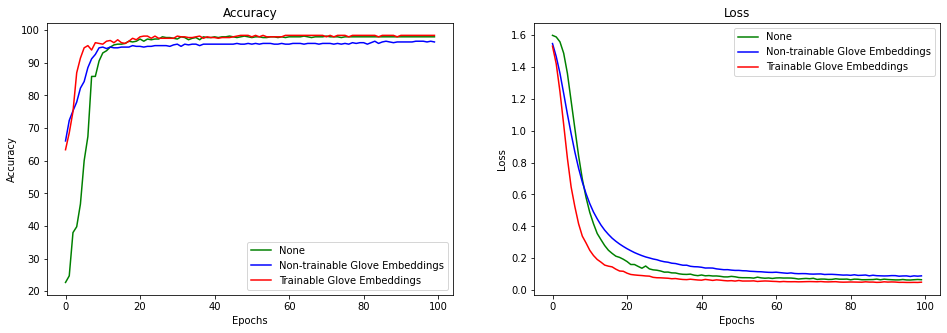

In [14]:
# Getting the values of accuracy and loss from history.
accuracy = np.array(history.history['val_accuracy'])*100
loss = history.history['val_loss']
epochs = range(len(accuracy))
accuracy1 = np.array(history1.history['val_accuracy'])*100
loss1 = history1.history['val_loss']
epochs1 = range(len(accuracy1))
accuracy2 = np.array(history2.history['val_accuracy'])*100
loss2 = history2.history['val_loss']
epochs2 = range(len(accuracy2))

# Plotting the graphs.
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title('Accuracy')
plt.plot(epochs, accuracy, 'g', label='None')
plt.plot(epochs1, accuracy1, 'b', label='Non-trainable Glove Embeddings')
plt.plot(epochs2, accuracy2, 'r', label='Trainable Glove Embeddings')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(122)
plt.title('Loss')
plt.plot(epochs, loss, 'g', label='None')
plt.plot(epochs1, loss1, 'b', label='Non-trainable Glove Embeddings')
plt.plot(epochs2, loss2, 'r', label='Trainable Glove Embeddings')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

----
<h3><b>Conclusions</b></h3>

* Both the models with trainable weights reach a validation accuracy of around 98%.
* Pre-trained embeddings initially help our model train faster, while initializing with random weights took some time.
* Trainable word embeddings gives more accurate prediction fast compared to Non-trainable word embeddings.
* Trainable word embeddings performs best among all these models.

---